# **EE488 Machine Learning Basics and Practices**
## **Mini-Assignment 3**

If you have any questions or encounter some problems in this assignment code, feel free to ask directly via **dy.kim@kaist.ac.kr**

## **Part 1.** Implement LSTM model using handcrafted 'MyLSTM' and 'MyLSTMCell' modules

In the last week 12 practice session(RNN), we've already run lstm model using ``nn.LSTM()`` which is built-in module of pytorch package. In this part, you will implement your own LSTM module (forward only, leaving backward implementation to pytorch autograd as we've done in ```batchnorm1d``` implementation in the last assignment). The target problem here is exactly the same with that of week12 practice session so you can refer to it.

In [1]:
from __future__ import unicode_literals, print_function, division
import numpy as np
import torch
import torch.nn as nn
import random
import math

#### **Character embedding**

In order to put characters of the sentence as input of RNN, we should implement character embedding before entering the model as input. There are several embedding methods, but here we use a embedding method which makes one-hot vector.

- **Character Embedding**: Convert each character to embedding vector
- **string_to_onehot**: Convert string to one-hot vector
- **onehot_to_string**: Convert one-hot vector to character (string list)

In [2]:
# Preprocessing string data
# alphabet(0-25), others(26~32), start(33) -> 34 chars

chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;0"
char_list = [i for i in chars]
char_len = len(char_list)
n_letters = len(char_list)

# String to one-hot vector
# a -> [1 0 0 ... 0 0], b -> [0 1 0 0 ... 0 0]

def string_to_onehot(string,seq_len=1):
    start = np.zeros(shape=len(char_list) ,dtype=int)
    end = np.zeros(shape=len(char_list) ,dtype=int)
    start[-1] = 1 # This is initial input

    # Insert zeros for initial input
    for i in range(seq_len):
        if i == 0:
            onehot = start
        else:
            onehot = np.vstack([start,onehot])

    # Convert string to one-hot vector
    for i in string:
        idx = char_list.index(i)
        zero = np.zeros(shape=char_len, dtype=int)
        zero[idx]=1
        onehot = np.vstack([onehot, zero])
    
    return onehot

# Onehot vector to word
# [1 0 0 ... 0 0] -> a 

def onehot_to_word(onehot_1):
    out = ''
    for i in range(onehot_1.shape[0]):
        onehot = onehot_1[i,:]
        out = out + char_list[onehot.argmax()]
    return out

#### **Settings the target problem**

In [3]:
# Recall the target problem
string = "hello pytorch. how long can a rnn cell remember? show me your limit!"
chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;0"
char_list = [i for i in chars]
char_len = len(char_list)
input_size = char_len
hidden_size = 50
output_size = char_len

# Additional settings
num_layers = 2
batch_size = 1
seq_len = 3 # In this time, we use seq_len as 3.
num_epochs = 400

one_hot = torch.tensor(string_to_onehot(string, seq_len).astype(np.float32)) #Convert the given sentence to one-hot vector
# Input of LSTM during training # Note that 3 zeros are inserted (since sequence length is 3)
onehot_to_word(one_hot)

'000hello pytorch. how long can a rnn cell remember? show me your limit!'

## **TODO1** : Fill in the blanks of the codes for **Task 1 ~ 3 below** and write your own description of the source code in your report.

## **TODO2** : Attach the results in your report.

### **Task 1. LSTMCell Module Implementation**

The following figure shows a single LSTM cell:

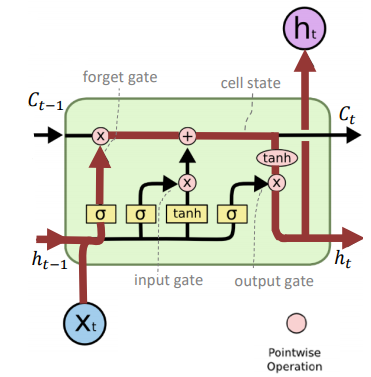

First of all, you will implement ```LSTMCell``` which will be used in the ```LSTM``` module. (please refer to https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html to grasp what parameters and methods are here and how each method works) 


**Hint: You can define the weights of LSTMCell by using either ```nn.Linear()``` or ```nn.Parameter()```.**

In [4]:
class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()
        # fill in the blank --------------------------------------
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fg_x = nn.Linear(input_size,hidden_size)
        self.fg_h = nn.Linear(hidden_size,hidden_size)
        self.ig_x = nn.Linear(input_size,hidden_size)
        self.ig_h = nn.Linear(hidden_size,hidden_size)
        self.og_x = nn.Linear(input_size,hidden_size)
        self.og_h = nn.Linear(hidden_size,hidden_size)
        self.cg_x = nn.Linear(input_size,hidden_size)
        self.cg_h = nn.Linear(hidden_size,hidden_size)

        # --------------------------------------------------------
        
    def forward(self, input, hidden_states):
        # fill in the blank --------------------------------------
        (hidden,cell) = hidden_states

        ft = torch.sigmoid(self.fg_x(input) + self.fg_h(hidden))
        it = torch.sigmoid(self.ig_x(input) + self.ig_h(hidden))
        ot = torch.sigmoid(self.og_x(input) + self.og_h(hidden))
        ct = torch.tanh(self.cg_x(input) + self.cg_h(hidden))

        new_cell = (ft*cell)+(it*ct)
        new_hidden = ot*torch.tanh(new_cell) 
        return (new_hidden,new_cell)
        # --------------------------------------------------------

### **Task 2. LSTM Module Implementation**
Secondly, ```LSTM``` module should be implemented to be used in the final model for solving the target problem. (please refer to https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html to grasp what parameters and methods are here and how each method works)

**Hint : Use MyLSTMCell and see the example section in https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html**

The following figure shows an example of MyLSTM:

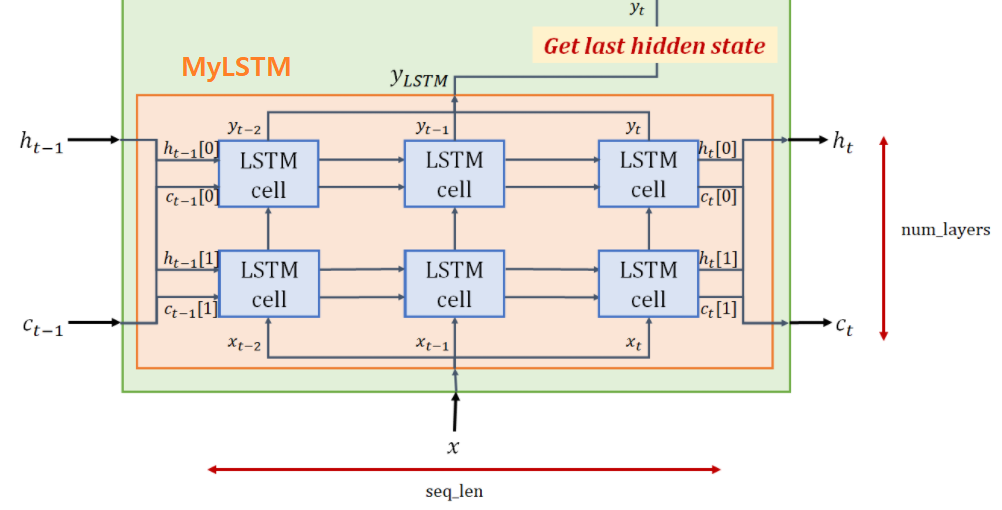

In [5]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MyLSTM, self).__init__()
        # fill in the blank --------------------------------------
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_1 = MyLSTMCell(input_size,hidden_size)
        self.lstm_2 = MyLSTMCell(hidden_size,hidden_size)
        # --------------------------------------------------------
    
    def forward(self, input, states):
        # fill in the blank --------------------------------------
        hidden, cell = states
        seq_len, batch, input_size = input.size()
        hidden_states=[]
        cell_states=[]
        y_states= []
        temp1=[]
        temp2=[]
        for i in range(self.num_layers):
          temp1.append(hidden[i])
          temp2.append(cell[i])
        hidden_states.append(temp1)
        cell_states.append(temp2)

        for i in range(seq_len):
          hidden_temp=[]
          cell_temp=[]
          for j in range(self.num_layers):
            k = self.num_layers-1-j
            if (j == 0):
              hidden,cell = self.lstm_1(input[i],(hidden_states[i][k],cell_states[i][k]))
              hidden_temp.append(hidden)
              cell_temp.append(cell)
            else:
              hidden,cell = self.lstm_2(hidden_temp[-1],(hidden_states[i][k],cell_states[i][k]))
              hidden_temp.append(hidden)
              cell_temp.append(cell)
          hidden_temp.reverse()
          cell_temp.reverse()             
          hidden_states.append(hidden_temp)
          cell_states.append(cell_temp)
          y_states.append(hidden_temp[0])
        yout = torch.stack(y_states,dim=0)                
        return yout,(hidden_states[seq_len-1],cell_states[seq_len-1])
        # --------------------------------------------------------

### **Task 3. Defining the final model which consists of LSTM and output Linear layer**

You can refer to the practice session material for a few blanks.

**Initialize hidden, cell states as zero in `init_hidden_cell` method**

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__()
        # fill in the blank --------------------------------------
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = MyLSTM(input_size,hidden_size,num_layers) 
        self.h2o = nn.Linear(hidden_size, output_size) # Adjust to output size utilizing linear layer

        # --------------------------------------------------------
        
    def forward(self, input, states):
        # fill in the blank --------------------------------------
        hidden,cell = states
        output_LSTM,(hidden,cell) = self.lstm(input,(hidden,cell))
        output = self.h2o(output_LSTM[-1,:,:]).reshape(batch_size,self.output_size) # Get last hidden state
        
        return output,hidden,cell

        # --------------------------------------------------------
    
    def init_hidden_cell(self, batch_size=1):
        # fill in the blank --------------------------------------
        hidden = torch.zeros(num_layers,batch_size,hidden_size)
        cell = torch.zeros(num_layers,batch_size,hidden_size)
        return hidden,cell

        # --------------------------------------------------------

#### **Training and evaluation the target problem**

In [7]:
# set random seed
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)# build model

lstm_model = Model(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

for i in range(num_epochs):
    total_loss = 0
    hidden, cell = lstm_model.init_hidden_cell(batch_size)

    for j in range(len(string)):

        input_data = one_hot[j:j + seq_len].reshape(seq_len, batch_size, -1)  # Load x_(t), x_(t+1), x_(t+2) and change the shape of input_data to (sequence length, batch size, input size)
        output, hidden, cell = lstm_model(input_data, (hidden, cell))         # Put the input and hidden state and cell state as input of lstm
        target = one_hot[j + seq_len].view(1,-1)                              # Load groundtruth of y_(t+2) from one-hot and change the shape to (batch size, output size)
        loss = criterion(output,target)                                       # Compute loss at each time step
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i%100 ==0:
        print('At {:3d}th epoch, Loss : {:0.4f}'.format(i, total_loss.item()))

At   0th epoch, Loss : 2.4418
At 100th epoch, Loss : 0.0032
At 200th epoch, Loss : 0.0027
At 300th epoch, Loss : 0.0001


In [8]:
hidden, cell = lstm_model.init_hidden_cell(batch_size)
input_data = one_hot[:seq_len].reshape(seq_len,batch_size,-1)

with torch.no_grad():
    for j in range(len(string)):
        output, hidden, cell = lstm_model(input_data, (hidden, cell))
        print(onehot_to_word(output.reshape(1, -1)), end="")
        input_data = torch.cat([input_data[1:], output.reshape(1, batch_size, -1)], axis=0)

hello pytorch. how long can a rnn cell remember? show me your limit!

## **Part 2.** Numpy Implementation of **autograd**, **torch-like Tensor** and **Module**

The objective of this part is to understand how the mechanism of autograd in APIs (pytorch, tensorflow, etc) actually work. How to obtain the gradients of all of the parameters computed through such exceedingly complicated computations? Some people use this beautifully well-made APIs as a 'blackbox' when studying, implementing or even doing research on something. However, it is very important to understant what's going on (even if it's not that deep) inside this blackbox when you run some simulations, make use of third party's source code and even understand it. I hope this assignment will be of some help to your future study. 

In [9]:
import numpy as np
import os 
from urllib import request
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import random

#### **Implementing 'torch-like Tensor' by subclassing Numpy array**

The following code is for impelementing torch-like tensor by subclassing the numpy ndarray to add some desired attributes(e.g. grad, backward_fn) and  mimic the pytorch's autograd mechanism. **The attribute 'grad' is for keeping and accumulating the gradients and 'backward_fn' is for tracking all the computations with corresponding backward function.** All the backward functions will be called consecutively all at once when `loss.backward()` is called

In [10]:
class Tensor(np.ndarray):

    def __new__(cls, input_array, requires_grad=False):
        obj = np.asarray(input_array).view(cls)
        obj.grad = None
        obj.requires_grad = requires_grad
        lambda_fn = lambda x: 0 if x is None else x
        obj.backward_fn = lambda leaf_grad: setattr(obj, 'grad', lambda_fn(obj.grad) + leaf_grad) if requires_grad else lambda *args: None
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.grad = getattr(obj, 'grad', None)
        self.requires_grad = getattr(obj, 'requires_grad', None)
        self.backward_fn = getattr(obj, 'backward_fn', None)

    def backward(self, *args):
        self.backward_fn(*args)

**Usage**

You can make **Tensor** by wrapping ```ndarray``` with the ```Tensor()``` class

In [11]:
array = np.random.randn(2, 3)
print(array.__repr__(), end='\n\n')

mytensor = Tensor(array) # wrap it with Tensor class
print(mytensor.__repr__())

array([[ 1.48860905,  0.67601087, -0.41845137],
       [-0.80652081,  0.55587583, -0.70550429]])

Tensor([[ 1.48860905,  0.67601087, -0.41845137],
        [-0.80652081,  0.55587583, -0.70550429]])


**You can use all of the operations and methods which are supported by numpy package**

In [12]:
addition = mytensor + mytensor
power_two = mytensor ** 2
max_zero = np.maximum(mytensor, 0)

addition, power_two, max_zero

(Tensor([[ 2.97721811,  1.35202174, -0.83690274],
         [-1.61304163,  1.11175166, -1.41100857]]),
 Tensor([[2.21595691, 0.4569907 , 0.17510155],
         [0.65047582, 0.30899794, 0.4977363 ]]),
 Tensor([[1.48860905, 0.67601087, 0.        ],
         [0.        , 0.55587583, 0.        ]]))

**The following descriptive figure is for understanding how autograd computes the gradient.**

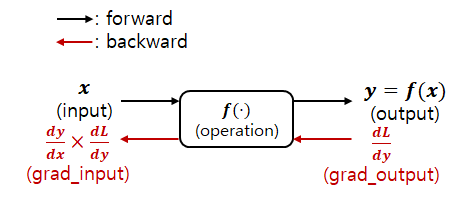

Backward function must be defined for all the forward operations like below. Pytorch package already implemented all the backward for all the basic vector/matrix operation. However, you can define the forward/backward "in chunk" containing multiple operations, not "basic operation level" (see below).

The following example is for implementing three basic operation (scalar addition, multiplication, power of two) using "closure" technique (see https://www.learnpython.org/en/Closures for details). The forward/backward function will be implemented as the following form.

```python
def forward(input):
    output = forward_operation(input)

    def backward(grad_output -> if required):
        grad_input = corresponding_backward_function(grad_output)
        input.backward_fn(grad_input)

    output.backward_fn = backward
    return output
```

 Corresponding backward function is attached to attribute "backward_fn" of the output Tensor when computing the forward operation. And then all these backward functions will be called consecutively. **(Note that if input is leaf variable, backward_fn just saves gradient in .grad attributes (or accumulate). See above code of Tensor class)**.

Now, let's consider the following example.

$f(a, b) = (a^2 + 1)^2b^2$

Taking derivative it with respect to $a$ and $b$ gives

$\dfrac{\partial f}{\partial a} = 2(a^2 + 1)(2a)b^2$
and
$\dfrac{\partial f}{\partial b} = 2b(a^2 + 1)^2$

Thus, we can implement forward/backward of $f$ (w.r.t $a$, $b$) as follows:

In [13]:
def f(a, b):
    output = (a ** 2 + 1) ** 2 * b ** 2

    def backward():
        grad_input_a = 2 * (a ** 2 + 1) * (2 * a) * b ** 2
        grad_input_b = 2 * b * (a ** 2 + 1) ** 2
        a.backward_fn(grad_input_a)
        b.backward_fn(grad_input_b)

    output.backward_fn = backward
    return output

Define 'a' and 'b' with 'required_grad = True' for tracking the computational graph. In this case, the backward_fn is for keeping/accumulating the gradient.

In [14]:
a = Tensor(2, requires_grad=True)
b = Tensor(3, requires_grad=True)

out = f(a, b)
out.backward()

# check the output and gradient
out, a.grad, b.grad

(Tensor(225), Tensor(360), Tensor(150))

Althogh it is very simple yet effective way of obtaining the gradient, it may impossible to define all the corresponding backward function for each (possibly infinite number of) forward function. To get around this problem, we can decompse it into more basic level operations like addition, multiplication, etc. This is how autograd works. See below.

### **Task 1. Implment backward of the following operations:**

```add()``` : addition of two operands

```mul()``` : multiplication of two operands

```pow_two()``` : taking power of two

Defualt argument in backward function is nothing but for the case of the last ```out.backward()``` call.

## **TODO1** : Fill in the blanks of the codes for **Task 1** and write your own description of the source code in your report. 

## **TODO2** : Attach the results in your report.

In [15]:
# It computes the output using only "handcrafted" basic level operations!
def f(a, b):
    # (a^2 + 1)^2 x b^2 = (a^2 x b + b)^2
    c = pow_two(a)
    d = mul(c, b)
    e = add(d, b)
    f = pow_two(e)
    return f


# handcrafted basic level operations
# addition
def add(a, b):
    # fill in the blank --------------------------------------
    output = a+b
    # --------------------------------------------------------
    def backward(grad_output=1):
        # fill in the blank --------------------------------------
        grad_input_a = 1
        grad_input_b = 1 
        a.backward_fn(grad_input_a*grad_output)
        b.backward_fn(grad_input_b*grad_output)
        # --------------------------------------------------------
    output.backward_fn = backward
    return output

# multiplication
def mul(a, b):
    # fill in the blank --------------------------------------
    output = a*b
    # --------------------------------------------------------
    def backward(grad_output=1):
        # fill in the blank --------------------------------------
        grad_input_a = b
        grad_input_b = a 
        a.backward_fn(grad_input_a*grad_output)
        b.backward_fn(grad_input_b*grad_output)
        # --------------------------------------------------------
    output.backward_fn = backward
    return output

# power of two
def pow_two(a):
    # fill in the blank --------------------------------------
    output = a **2
    # --------------------------------------------------------
    def backward(grad_output=1):
        # fill in the blank --------------------------------------
        grad_input_a = 2*a
        a.backward_fn(grad_input_a*grad_output)
        # --------------------------------------------------------
    output.backward_fn = backward
    return output

In [16]:
# define 'a' and 'b' with 'required_grad = True' to track the computational graph. In this case, the backward_fn is for keeping/accumulating the gradient.
a = Tensor(2, requires_grad=True)
b = Tensor(3, requires_grad=True)

out = f(a, b)
out.backward()

# check the output and gradient
out, a.grad, b.grad

(Tensor(225), Tensor(360), Tensor(150))

backward() is called once more -> the gradients are accumulated

In [17]:
out.backward()
out, a.grad, b.grad

(Tensor(225), Tensor(720), Tensor(300))

If the .requires_grad is False, the gradient will not be saved in corresponding variable,

In [18]:
a = Tensor(2, requires_grad=True)
b = Tensor(3)

out = f(a, b)
out.backward()

out, a.grad, b.grad

(Tensor(225), Tensor(360), None)

#### **Implementing 'torch-like Module' to be inherited to customed modules**
It contains several useful methods and implemented compactly, trying to make it along the same line with `nn.Module` in pytorch. (except for the ```update``` method). See https://pytorch.org/docs/stable/generated/torch.nn.Module.html for details of each method usage.

Since all the effective SGD variants other than naive one is out of scope in this assignment, we will not investigate on 'torch-like optimizer'. Instead, we will make the 'Module' class absorb this update procedure in ```update``` method. Learning rate (```lr```) must be specified in every iteration as a method's argument.



### **Task 2. Implment ```zero_grad()``` and ```update()``` methods**

**hint:** use ```parameters()``` method.

## **TODO1** : Fill in the blanks of the codes for **Task 2** and write your own description of the source code in your report. 

## **TODO2** : Attach the results in your report.

In [19]:
class Module:
    def __init__(self):
        self.training = True
        self._parameters = dict()
        self._modules = dict()

    def __setattr__(self, name, value):
        super(Module, self).__setattr__(name, value)
        if isinstance(value, Tensor) and value.requires_grad:
            self._parameters[name] = value
        elif isinstance(value, Module):
            self._modules[name] = value

    def modules(self):
        yield self
        for name, module in self._modules.items():
            if module is None:
                continue
            for m in module.modules():
                yield m
        
    def parameters(self):
        modules = self.modules()
        for module in modules:
            members = module._parameters.items()
            for k, v in members:
                yield v

    def zero_grad(self):
        # fill in the blank --------------------------------------
        for v in self.parameters():
          v.grad =0
        # --------------------------------------------------------

    def update(self, lr):
        # fill in the blank --------------------------------------
        for v in self.parameters():
          v -= lr*v.grad
        # --------------------------------------------------------

    def train(self):
        for module in self.modules():
            module.training = True

    def eval(self):
        for module in self.modules():
            module.training = False

    def forward(self, *args):
        raise NotImplementedError

    def __call__(self, *args):
        return self.forward(*args)

**Usage**

You can subclass it when you implement the customed modules(e.g. relu, fc layer) as well as the full model which will be defined in the similar way with torch's Module.

In [20]:
class TestModel(Module):
    def __init__(self, init_param):
        super(TestModel, self).__init__()
        self.some_param = Tensor(init_param, requires_grad=True)
    
    def forward(self, x):
        return f(self.some_param, x)  ## f is defined above in Part1-Task1
    
test_model = TestModel(12.)
out = test_model(Tensor(0.3))
out.backward()

print('gradient of some_param before zero_grad : ', test_model.some_param.grad)
print('some_param before update : ', test_model.some_param)
test_model.update(lr=0.01)
print('some_param after update : ', test_model.some_param)
test_model.zero_grad()
print('gradient of some_param after zero_grad : ', test_model.some_param.grad)

gradient of some_param before zero_grad :  626.3999999999999
some_param before update :  12.0
some_param after update :  5.7360000000000015
gradient of some_param after zero_grad :  0


#### **Recap Deep Neural Network (DNN) Training**

Let's recap deep neural network which was already covered by week 9 practice session meterial. In this sub-part, you will implement DNN model by using the above `Tensor, Model, Autograd mechanism`. You can fill in the blank based on the week 9 practice session meterial if you think you need. At first, some key modules (e.g. full-connected layer, ReLU activation) will be implemented and wrapping(using) them with a whole model which also must inherit the `Module` class. And then train with MNIST and CIFAR10 dataset to check the result.



#### **1. Training on MNIST Dataset**
#### **Load MNIST Dataset**

In [21]:
#Download MNIST Dataset

if not os.path.exists('mnist'):
    os.mkdir('mnist')
# try:
mnist_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"
files = ["train-images-idx3-ubyte.gz","t10k-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz","t10k-labels-idx1-ubyte.gz"]
for file in files: 
    if not os.path.isfile('mnist/'+file):
        request.urlretrieve(mnist_url+file, 'mnist/'+file)

#Prepare MNIST Dataset
with gzip.open('mnist/train-images-idx3-ubyte.gz', 'r') as f:
    magic_number = int.from_bytes(f.read(4), 'big')
    num_images_training = int.from_bytes(f.read(4), 'big')
    row_count = int.from_bytes(f.read(4), 'big')
    column_count = int.from_bytes(f.read(4), 'big')
    train_images_data = f.read()
    train_images = np.frombuffer(train_images_data, dtype=np.uint8).reshape(num_images_training, row_count, column_count)

with gzip.open('mnist/train-labels-idx1-ubyte.gz', 'r') as f:
    magic_number = int.from_bytes(f.read(4), 'big')
    label_count = int.from_bytes(f.read(4), 'big')
    train_labels_data = f.read()
    train_labels = np.frombuffer(train_labels_data, dtype=np.uint8)

with gzip.open('mnist/t10k-images-idx3-ubyte.gz', 'r') as f:
    magic_number = int.from_bytes(f.read(4), 'big')
    num_images_test = int.from_bytes(f.read(4), 'big')
    row_count = int.from_bytes(f.read(4), 'big')
    column_count = int.from_bytes(f.read(4), 'big')
    test_images_data = f.read()
    test_images = np.frombuffer(test_images_data, dtype=np.uint8).reshape(num_images_test, row_count, column_count)

with gzip.open('mnist/t10k-labels-idx1-ubyte.gz', 'r') as f:
    magic_number = int.from_bytes(f.read(4), 'big')
    label_count = int.from_bytes(f.read(4), 'big')
    test_labels_data = f.read()
    test_labels = np.frombuffer(test_labels_data, dtype=np.uint8) 

train_images = Tensor(train_images / 255.)
test_images = Tensor(test_images / 255.)
train_labels = Tensor(train_labels)
test_labels = Tensor(test_labels)

print("Training Images Shape:" , train_images.shape)
print("Training Labels Shape:" ,train_labels.shape)
print("Test Images Shape:" ,test_images.shape)
print("Test Labels Shape:" ,test_labels.shape)

Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


The following model is desired to be trained on MNIST dataset at the end of this sub-part, and as you can see the below cell, you need to implement the following modules:

`Linear`, `ReLU`

The usage of these modules are exactly the same with that of pytorch.

In [22]:
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = Linear(784, 320)
        self.fc2 = Linear(320, 120)
        self.fc3 = Linear(120, 10)
        self.relu = ReLU()

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### **Task 3. Implement the ReLU, Linear modules(with backward)**



### **Task 4. Implement CrossEntropyLoss(with backward) to define appropriate criterion before training**



## **TODO1** : Fill in the blanks of the codes for **Task 3, 4** and write your own description of the source code in your report. 

## **TODO2** : Attach the results in your report.

In [23]:
class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        return relu_function(x)


def relu_function(input):
    # fill in the blank --------------------------------------
    output = input * 1*(input>0)
    # --------------------------------------------------------
    def backward(grad_output):
        # fill in the blank --------------------------------------
        grad_input = 1*(input>0)
        input.backward_fn(grad_input*grad_output)    
        # --------------------------------------------------------
        
    output.backward_fn = backward
    return output

In [24]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.init_parameters()

    def init_parameters(self):
        W = np.random.randn(self.in_features, self.out_features) * math.sqrt(2 / (6 * self.in_features))
        bound = 1 / math.sqrt(self.in_features)
        b = np.random.uniform(-bound, bound, size=(self.out_features))
        self.W = Tensor(W, requires_grad=True)
        self.b = Tensor(b, requires_grad=True)

    def forward(self, x):
        return wx_plus_b(self.W, self.b, x)


def wx_plus_b(W, b, input):
    # fill in the blank --------------------------------------
    output = np.matmul(input,W) + b
    # --------------------------------------------------------
    def backward(grad_output):
        # fill in the blank --------------------------------------
        grad_input_W = input.T
        grad_input_x = W.T
        W.backward_fn(np.matmul(grad_input_W,grad_output)/100)
        input.backward_fn(np.matmul(grad_output,grad_input_x))
        b.backward_fn(np.sum(grad_output, axis=0)/100)
        # --------------------------------------------------------

    output.backward_fn = backward
    return output

**Implement CrossEntropyLoss which combines `LogSoftmax` and `NLL Loss` as pytorch's one does.**

(see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [25]:
class CrossEntropyLoss:
    def __call__(self, input, target):
        return compute_cross_entropy_loss(input, target)


def compute_cross_entropy_loss(input, target):
 # fill in the blank --------------------------------------
    l = len(input)
    q = np.log(np.sum(np.exp(input),axis=1))
    sum = 0
    for i in range(l):
      sum +=  -1*input[i][target[i]] + q[i]
    v = sum/l
    output = Tensor(v, requires_grad=True)

    # --------------------------------------------------------
    def backward():
        # fill in the blank --------------------------------------
        n,c = input.shape[0], input.shape[1]
        grad_input_i = Tensor(np.zeros(input.shape),requires_grad=True) 
        p = torch.sum(torch.exp(torch.Tensor(input)),axis =1)
        for i in range(n):
          for j in range(c):
            t = target[i]
            if j == t:
              grad_input_i[i][j] = math.exp(input[i][j])/p[i] -1
            else:
              grad_input_i[i][j] = math.exp(input[i][j])/p[i]
        input.backward_fn(grad_input_i)
        # --------------------------------------------------------

    output.backward_fn = backward
    return output

#### **Training and Evaluation**

In [26]:
np.random.seed(2021)
random.seed(2021)
model = Model()
criterion = CrossEntropyLoss()
epoch = 20
batch_size = 100
assert len(train_images) % batch_size == 0
lr = 0.1
for i in tqdm(range(epoch)):
    indices = np.arange(len(train_images))
    np.random.shuffle(indices)
    train_images_shuffle = train_images[indices]
    train_labels_shuffle = train_labels[indices]
    running_loss = 0.0
    for num_batch in range(len(train_images) // batch_size):
        imgs = train_images_shuffle[num_batch * batch_size:(num_batch + 1) * batch_size]
        target = train_labels_shuffle[num_batch * batch_size:(num_batch + 1) * batch_size]
        output = model(imgs)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        model.update(lr)
        running_loss += loss      
    print('Loss = {}'.format(running_loss/(num_batch + 1)))
print('Training Finished')

  5%|▌         | 1/20 [00:22<07:01, 22.20s/it]

Loss = 0.5781777946939585


 10%|█         | 2/20 [00:44<06:38, 22.11s/it]

Loss = 0.22873719532443318


 15%|█▌        | 3/20 [01:06<06:15, 22.07s/it]

Loss = 0.1640410724755691


 20%|██        | 4/20 [01:28<05:52, 22.05s/it]

Loss = 0.1257603994957947


 25%|██▌       | 5/20 [01:50<05:31, 22.08s/it]

Loss = 0.10119685747190237


 30%|███       | 6/20 [02:12<05:08, 22.00s/it]

Loss = 0.08333178600107863


 35%|███▌      | 7/20 [02:34<04:46, 22.01s/it]

Loss = 0.07027924708791247


 40%|████      | 8/20 [02:55<04:23, 21.93s/it]

Loss = 0.06055773553076713


 45%|████▌     | 9/20 [03:17<04:01, 21.95s/it]

Loss = 0.05177557093455945


 50%|█████     | 10/20 [03:39<03:38, 21.87s/it]

Loss = 0.044975764742171215


 55%|█████▌    | 11/20 [04:01<03:16, 21.80s/it]

Loss = 0.03923449391013921


 60%|██████    | 12/20 [04:22<02:54, 21.76s/it]

Loss = 0.03359318136054477


 65%|██████▌   | 13/20 [04:44<02:32, 21.77s/it]

Loss = 0.029359092377834753


 70%|███████   | 14/20 [05:06<02:10, 21.82s/it]

Loss = 0.02638559426859062


 75%|███████▌  | 15/20 [05:28<01:49, 21.94s/it]

Loss = 0.02188277657225809


 80%|████████  | 16/20 [05:50<01:28, 22.01s/it]

Loss = 0.019211439694421316


 85%|████████▌ | 17/20 [06:12<01:06, 22.01s/it]

Loss = 0.016606912947774433


 90%|█████████ | 18/20 [06:34<00:43, 21.92s/it]

Loss = 0.014621049770453896


 95%|█████████▌| 19/20 [06:56<00:21, 21.89s/it]

Loss = 0.01248915659717752


100%|██████████| 20/20 [07:18<00:00, 21.92s/it]

Loss = 0.0109020433180678
Training Finished


In [27]:
prediction = model(test_images)
prediction_label = np.argmax(prediction, axis=1)
test_acc = np.sum((prediction_label == test_labels))/len(test_labels)
print('Test Accuracy = {:.2f}'.format(100*test_acc))

Test Accuracy = 98.12


#### **2. Training on CIFAR-10 Dataset**
#### **Load CIFAR-10 Dataset**

As we've done in the last assignment, we will extract only 4 classes out of 10 to be classified and train model on these classes.

In [28]:
#Download CIFAR10 Dataset
from urllib import request
import pickle

request.urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 'cifar-10-python.tar.gz')
!tar -xzf cifar-10-python.tar.gz

for i in range(1,6):
    filename='data_batch_%d'%i
    with open('cifar-10-batches-py/'+filename, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
  
    images_batch = dict_data[b'data']
    labels_batch = dict_data[b'labels']
    if i==1:
        train_images = images_batch
        train_labels = labels_batch
    else:
        train_images = np.concatenate((train_images, images_batch), axis=0)
        train_labels.extend(labels_batch)
        
with open('cifar-10-batches-py/test_batch', 'rb') as fo:
    dict_data = pickle.load(fo, encoding='bytes')

test_images = dict_data[b'data']
test_labels = dict_data[b'labels']

train_indexes = sorted(range(len(train_labels)), key=lambda k: train_labels[k])
test_indexes = sorted(range(len(test_labels)), key=lambda k: test_labels[k])

def cifar10_subset(class_ind=[0,1]):
    assert (len(class_ind) >=2 and len(class_ind) <=10)
    assert (min(class_ind) >=0 and max(class_ind) <=9)
    train_images_cl = []
    train_labels_cl = []
    test_images_cl = []
    test_labels_cl = []
    for i in class_ind:
        train_inds = train_indexes[i*5000:(i+1)*5000]
        test_inds = test_indexes[i*1000:(i+1)*1000]
        train_images_tmp = train_images[train_inds,:]
        train_labels_tmp = np.array(train_labels)[train_inds]
        test_images_tmp = test_images[test_inds,:]
        test_labels_tmp = np.array(test_labels)[test_inds]

        train_images_cl.append(train_images_tmp)
        train_labels_cl.append(train_labels_tmp)
        test_images_cl.append(test_images_tmp)
        test_labels_cl.append(test_labels_tmp)
  
    return np.concatenate(train_images_cl), np.array(train_labels_cl), np.concatenate(test_images_cl), np.array(test_labels_cl)

X_train, Y_train, X_test, Y_test = cifar10_subset([0, 1, 2, 3])  # four classes

train_images = Tensor(X_train / 255.)
test_images = Tensor(X_test / 255.)
train_labels = Tensor(Y_train.reshape(-1))
test_labels = Tensor(Y_test.reshape(-1))

print("Training Images Shape:" , train_images.shape)
print("Training Labels Shape:" ,train_labels.shape)
print("Test Images Shape:" ,test_images.shape)
print("Test Labels Shape:" ,test_labels.shape)

Training Images Shape: (20000, 3072)
Training Labels Shape: (20000,)
Test Images Shape: (4000, 3072)
Test Labels Shape: (4000,)


#### **Define the model which will be trained on CIFAR-10**

In [29]:
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = Linear(3072, 640)
        self.fc2 = Linear(640, 320)
        self.fc3 = Linear(320, 64)
        self.fc4 = Linear(64, 4)
        self.relu = ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### **Training and Evaluation**

In [30]:
np.random.seed(2021)
random.seed(2021)

model = Model()
criterion = CrossEntropyLoss()

epoch = 30
batch_size = 100
assert len(train_images) % batch_size == 0
lr = 0.1
for i in tqdm(range(epoch)):
    indices = np.arange(len(train_images))
    np.random.shuffle(indices)
    train_images_shuffle = train_images[indices]
    train_labels_shuffle = train_labels[indices]
    running_loss = 0.0
    for num_batch in range(len(train_images) // batch_size):
        imgs = train_images_shuffle[num_batch * batch_size:(num_batch + 1) * batch_size]
        target = train_labels_shuffle[num_batch * batch_size:(num_batch + 1) * batch_size]
        output = model(imgs)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        model.update(lr)
        running_loss += loss      
    print('Loss = {}'.format(running_loss/(num_batch + 1)))
print('Training Finished')

  3%|▎         | 1/30 [00:16<08:00, 16.56s/it]

Loss = 1.2582670023415816


  7%|▋         | 2/30 [00:32<07:41, 16.50s/it]

Loss = 1.0919951508004484


 10%|█         | 3/30 [00:49<07:25, 16.50s/it]

Loss = 1.00561870092553


 13%|█▎        | 4/30 [01:05<07:08, 16.49s/it]

Loss = 0.9637869468715854


 17%|█▋        | 5/30 [01:22<06:51, 16.45s/it]

Loss = 0.9254566579690754


 20%|██        | 6/30 [01:38<06:34, 16.43s/it]

Loss = 0.8892995711565709


 23%|██▎       | 7/30 [01:54<06:17, 16.40s/it]

Loss = 0.8592798627312358


 27%|██▋       | 8/30 [02:11<06:01, 16.42s/it]

Loss = 0.8584353847176592


 30%|███       | 9/30 [02:27<05:44, 16.41s/it]

Loss = 0.8277142604913215


 33%|███▎      | 10/30 [02:44<05:28, 16.44s/it]

Loss = 0.8027028210928258


 37%|███▋      | 11/30 [03:00<05:12, 16.46s/it]

Loss = 0.7792771799979189


 40%|████      | 12/30 [03:17<04:58, 16.60s/it]

Loss = 0.7655082703577495


 43%|████▎     | 13/30 [03:34<04:43, 16.69s/it]

Loss = 0.7405931547794254


 47%|████▋     | 14/30 [03:51<04:26, 16.68s/it]

Loss = 0.7206759232191874


 50%|█████     | 15/30 [04:08<04:10, 16.70s/it]

Loss = 0.7131060567937797


 53%|█████▎    | 16/30 [04:24<03:53, 16.66s/it]

Loss = 0.7172370026266394


 57%|█████▋    | 17/30 [04:41<03:35, 16.60s/it]

Loss = 0.6800015122822465


 60%|██████    | 18/30 [04:57<03:18, 16.58s/it]

Loss = 0.6773129184500734


 63%|██████▎   | 19/30 [05:14<03:01, 16.52s/it]

Loss = 0.6583498611888343


 67%|██████▋   | 20/30 [05:30<02:45, 16.50s/it]

Loss = 0.6512438799563115


 70%|███████   | 21/30 [05:46<02:28, 16.46s/it]

Loss = 0.6305094876835061


 73%|███████▎  | 22/30 [06:03<02:11, 16.45s/it]

Loss = 0.611703107474812


 77%|███████▋  | 23/30 [06:19<01:54, 16.42s/it]

Loss = 0.6174110149762465


 80%|████████  | 24/30 [06:35<01:38, 16.41s/it]

Loss = 0.5962815868056617


 83%|████████▎ | 25/30 [06:52<01:22, 16.41s/it]

Loss = 0.5968599266443294


 87%|████████▋ | 26/30 [07:08<01:05, 16.45s/it]

Loss = 0.5718190408421328


 90%|█████████ | 27/30 [07:25<00:49, 16.43s/it]

Loss = 0.5613237884032598


 93%|█████████▎| 28/30 [07:41<00:32, 16.46s/it]

Loss = 0.5500586091577057


 97%|█████████▋| 29/30 [07:58<00:16, 16.55s/it]

Loss = 0.5268478581278095


100%|██████████| 30/30 [08:15<00:00, 16.52s/it]

Loss = 0.5286575279149609
Training Finished


In [31]:
prediction = model(test_images)
prediction_label = np.argmax(prediction, axis=1)
test_acc = np.sum((prediction_label == test_labels))/len(test_labels)
print('Test Accuracy = {:.2f}'.format(100*test_acc))

Test Accuracy = 71.58
